# CNN Model — Emission Point Classification Using Temporal Sensor Windows

This notebook develops a 1D Convolutional Neural Network (CNN) to classify the emission source point (E1, E2, E3) of particles in a simulated industrial environment. Unlike previous approaches based on static features, this model leverages **temporal sensor data** segmented into **sliding windows**, capturing local temporal patterns to improve classification accuracy.

The dataset used is `complete_dataset.csv`, containing timestamped sensor readings per simulation (`tag`). Each tag represents a simulated event where one of the emission classes occurs. The model uses grouped time sequences to predict the emission class based on temporal behavior.

---

## Notebook Structure

1. Import Required Libraries and Configure GPU
2. Load Dataset and Remove Constant Sensors
3. Hold Out 10% for Generalization Testing
4. Create Temporal Windows for CNN Input
5. Encode Labels and Normalize Data per Fold
6. CNN Model Architecture and Random Hyperparameter Search
7. Cross-Validation Evaluation with Scientific Metrics:
   - Accuracy
   - Macro Precision
   - Macro Recall
   - Macro F1-Score
   - Cohen’s Kappa
8. Summary of Results and Best Model Configuration

---

This notebook is structured for scientific reproducibility and evaluation. We apply **Group K-Fold Cross-Validation** to avoid data leakage between simulations (`tag`). All preprocessing (scaling, encoding) is done **within folds only**. Results are aggregated across folds and reported with **scientific rigor**, allowing this work to be extended for academic publishing or technical reporting.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1.1 Fixar seeds para reproducibilidade
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"NumPy    version: {np.__version__}")
print(f"Pandas   version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")

NumPy    version: 1.26.4
Pandas   version: 2.2.3
TensorFlow version: 2.10.0


In [2]:
df = pd.read_csv('../data/processed/dataset_timeseries.csv')

print("Contagem por classe de emissão:")
display(df['classe'].value_counts())
print("Valores ausentes por coluna:")
display(df.isnull().sum())
print("Shape do Dataframe: ", df.shape)
display(df.head())

Contagem por classe de emissão:


classe
E1    7938
E2    7938
E3    7076
Name: count, dtype: int64

Valores ausentes por coluna:


f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f9896     0
f9897     0
f9898     0
f9899     0
classe    0
Length: 9901, dtype: int64

Shape do Dataframe:  (22952, 9901)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f9891,f9892,f9893,f9894,f9895,f9896,f9897,f9898,f9899,classe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.37827,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E1


In [3]:
# Toda coluna exceto 'classe' são features achatadas
X_flat = df.drop(columns=['classe']).values  
y_raw  = df['classe'].values

In [4]:
WINDOW_SIZE = 30   # igual ao script
n_features  = X_flat.shape[1]
n_sensores  = n_features // WINDOW_SIZE

# reshape para (n_amostras, timesteps, canais)
X = X_flat.reshape(-1, WINDOW_SIZE, n_sensores)
print("X shape:", X.shape)  # deverá ser (n_amostras, 30, n_sensores)

X shape: (22952, 30, 330)


In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_int = le.fit_transform(y_raw)        # E1→0, E2→1, E3→2, por exemplo
y    = to_categorical(y_int)           # one-hot para softmax

In [6]:
from sklearn.model_selection import train_test_split

# Etapa 1: separa 20% para teste (generalização final)
X_remain, X_test, y_remain, y_test, y_int_remain, y_int_test = train_test_split(
    X, y, y_int, test_size=0.2, random_state=42, stratify=y_int
)

# Etapa 2: divide o restante em treino (75% de 80% = 60%) e validação (25% de 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_remain, y_remain, test_size=0.25, random_state=42, stratify=y_int_remain
)

In [10]:
# 4. Definição e Compilação da Arquitetura CNN-1D

from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam

# 4.1 Parâmetros com base na nova divisão (X_train)
n_steps, n_sensors = X_train.shape[1], X_train.shape[2]
n_classes = y_train.shape[1]  # número de categorias (E1, E2, E3)

# 4.2 Arquitetura da CNN-1D
inp = Input(shape=(n_steps, n_sensors), name="input_series")

x = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(inp)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(n_classes, activation="softmax", name="class_output")(x)

model = Model(inputs=inp, outputs=output, name="CNN1D_Emissao")
model.summary()

# 4.3 Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


Model: "CNN1D_Emissao"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_series (InputLayer)   [(None, 30, 330)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 32)            31712     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 15, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 7, 128)          

In [13]:
# 5. Treinamento do Modelo com EarlyStopping e ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 5.1 EarlyStopping para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 5.2 Checkpoint usando o formato SavedModel (sem extensão ou com .keras)
checkpoint = ModelCheckpoint(
    '../models/best_cnn1d_emissao.keras',  # salvar como arquivo .keras (formato moderno)
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    save_format='keras'  # explícito
)

# 5.3 Treinamento com validação
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
497/503 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9553
Epoch 1: val_loss improved from inf to 0.08837, saving model to ../models\best_cnn1d_emissao.keras
503/503 [==============================] - 3s 5ms/step - loss: 0.0929 - accuracy: 0.9554 - val_loss: 0.0884 - val_accuracy: 0.9585
Epoch 2/50
499/503 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9554
Epoch 2: val_loss did not improve from 0.08837
503/503 [==============================] - 3s 5ms/step - loss: 0.0923 - accuracy: 0.9554 - val_loss: 0.0885 - val_accuracy: 0.9585
Epoch 3/50
503/503 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9541
Epoch 3: val_loss did not improve from 0.08837
503/503 [==============================] - 3s 5ms/step - loss: 0.1055 - accuracy: 0.9541 - val_loss: 0.1066 - val_accuracy: 0.9559
Epoch 4/50
498/503 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9538
Epoch 4: val_loss did not impr


Test Loss: 0.0929
Test Accuracy: 0.9553
108/108 [==============================] - 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

          E1       0.89      1.00      0.94      1195
          E2       1.00      1.00      1.00      1198
          E3       1.00      0.85      0.92      1050

    accuracy                           0.96      3443
   macro avg       0.96      0.95      0.95      3443
weighted avg       0.96      0.96      0.95      3443



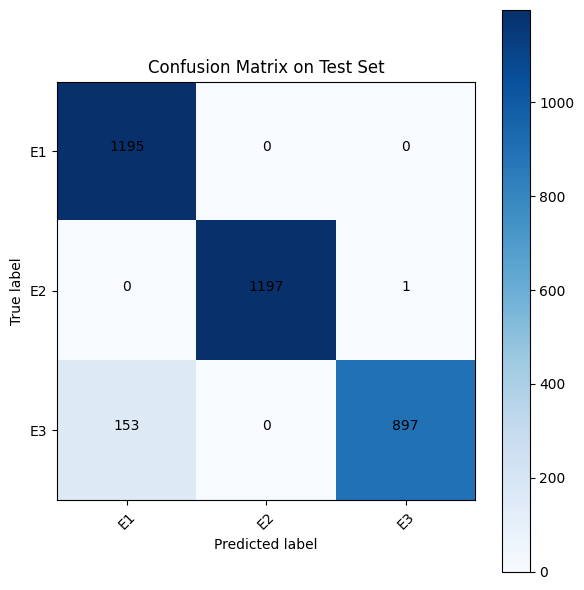

In [14]:
# 6. Avaliação Final no Conjunto de Teste (Generalização)

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 6.1 Carregar o melhor modelo salvo
model_final = load_model('best_cnn1d_emissao.keras')

# 6.2 Avaliação no conjunto de teste
loss, acc = model_final.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

# 6.3 Previsões
y_pred_probs = model_final.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 6.4 Relatório de Classificação
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 6.5 Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

# Anotar valores na matriz
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()